# MLFlow Trackingによる可視化の記録

MLFlow Trackingのアーティファクトとして、どのようなファイルであっても含めることはできる。
特に画像ファイルはWeb UIから直接閲覧することも可能である。

ここでは先ほど機械学習モデルを生成したときに使用した apple_data を用いて、さまざまな可視化したものが格納される様子を確認する。
途中に保存される画像がどのようなものかはここでは触れず、どのように格納されるかに注力するものとする。

In [1]:
import math
import pathlib
from datetime import datetime, timedelta

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    median_absolute_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

import mlflow

## データの取り込み

In [2]:
df = pd.read_csv('apple_data.csv', parse_dates=[0])
df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,1996-12-02 23:45:11.240034,30.584727,1.831006,0,0,1.578387,1,1001.647352,1026.324266,0.755725,0.323086
1,1996-12-03 23:45:11.240032,15.465069,0.761303,0,0,1.965125,0,843.972638,1026.324266,0.913934,0.030371
2,1996-12-04 23:45:11.240031,10.786525,1.427338,0,0,1.497623,0,890.319248,868.942267,2.879262,0.354226
3,1996-12-05 23:45:11.240030,23.648154,3.737435,0,0,1.952936,0,811.206168,889.965021,0.826015,0.953000
4,1996-12-06 23:45:11.240029,13.861391,5.598549,0,0,2.059993,0,822.279469,835.253168,1.130145,0.953000
...,...,...,...,...,...,...,...,...,...,...,...
9995,2024-04-14 23:45:11.226286,23.358868,7.061220,1,0,1.556829,1,2566.432998,2676.279445,0.560507,0.889971
9996,2024-04-15 23:45:11.226284,14.859048,0.868655,0,0,1.632918,1,2032.827646,2590.543027,2.460766,0.884467
9997,2024-04-16 23:45:11.226283,17.941035,13.739986,0,0,0.827723,1,2167.417581,2031.943179,1.321922,0.884467
9998,2024-04-17 23:45:11.226281,14.533862,1.610512,0,0,0.589172,1,2099.505096,2166.533113,2.604095,0.812706


In [3]:
df.dtypes

date                       datetime64[ns]
average_temperature               float64
rainfall                          float64
weekend                             int64
holiday                             int64
price_per_kg                      float64
promo                               int64
demand                            float64
previous_days_demand              float64
competitor_price_per_kg           float64
marketing_intensity               float64
dtype: object

## 可視化関数の定義

### Time Series Visualization of Demand

In [4]:
def plot_time_series_demand(data, window_size=7, style="ggplot", plot_size=(16, 12)):
    if not isinstance(data, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame.")

    df = data.copy()

    df["date"] = pd.to_datetime(df["date"])

    # Calculate the rolling average
    df["rolling_avg"] = df["demand"].rolling(window=window_size).mean()

    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        # Plot the original time series data with low alpha (transparency)
        ax.plot(df["date"], df["demand"], "b-o", label="Original Demand", alpha=0.15)
        # Plot the rolling average
        ax.plot(
            df["date"],
            df["rolling_avg"],
            "r",
            label=f"{window_size}-Day Rolling Average",
        )

        # Set labels and title
        ax.set_title(
            f"Time Series Plot of Demand with {window_size} day Rolling Average",
            fontsize=14,
        )
        ax.set_xlabel("Date", fontsize=12)
        ax.set_ylabel("Demand", fontsize=12)

        # Add legend to explain the lines
        ax.legend()
        plt.tight_layout()

    plt.close(fig)
    return fig

### Visualizing Demand on Weekends vs. Weekdays with Box Plots

In [5]:
def plot_box_weekend(df, style="ggplot", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        sns.boxplot(data=df, x="weekend", y="demand", ax=ax, color="lightgray")
        sns.stripplot(
            data=df,
            x="weekend",
            y="demand",
            ax=ax,
            hue="weekend",
            palette={0: "blue", 1: "green"},
            alpha=0.15,
            jitter=0.3,
            size=5,
        )

        ax.set_title("Box Plot of Demand on Weekends vs. Weekdays", fontsize=14)
        ax.set_xlabel("Weekend (0: No, 1: Yes)", fontsize=12)
        ax.set_ylabel("Demand", fontsize=12)
        for i in ax.get_xticklabels() + ax.get_yticklabels():
            i.set_fontsize(10)
        ax.legend_.remove()
        plt.tight_layout()
    plt.close(fig)
    return fig

### Exploring the Relationship Between Demand and Price per Kg

In [6]:
def plot_scatter_demand_price(df, style="ggplot", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        # Scatter plot with jitter, transparency, and color-coded based on weekend
        sns.scatterplot(
            data=df,
            x="price_per_kg",
            y="demand",
            hue="weekend",
            palette={0: "blue", 1: "green"},
            alpha=0.15,
            ax=ax,
        )
        # Fit a simple regression line for each subgroup
        sns.regplot(
            data=df[df["weekend"] == 0],
            x="price_per_kg",
            y="demand",
            scatter=False,
            color="blue",
            ax=ax,
        )
        sns.regplot(
            data=df[df["weekend"] == 1],
            x="price_per_kg",
            y="demand",
            scatter=False,
            color="green",
            ax=ax,
        )

        ax.set_title("Scatter Plot of Demand vs Price per kg with Regression Line", fontsize=14)
        ax.set_xlabel("Price per kg", fontsize=12)
        ax.set_ylabel("Demand", fontsize=12)
        for i in ax.get_xticklabels() + ax.get_yticklabels():
            i.set_fontsize(10)
        plt.tight_layout()
    plt.close(fig)
    return fig

### Visualizing Demand Density: Weekday vs. Weekend

In [7]:
def plot_density_weekday_weekend(df, style="ggplot", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)

        # Plot density for weekdays
        sns.kdeplot(
            df[df["weekend"] == 0]["demand"],
            color="blue",
            label="Weekday",
            ax=ax,
            fill=True,
            alpha=0.15,
        )

        # Plot density for weekends
        sns.kdeplot(
            df[df["weekend"] == 1]["demand"],
            color="green",
            label="Weekend",
            ax=ax,
            fill=True,
            alpha=0.15,
        )

        ax.set_title("Density Plot of Demand by Weekday/Weekend", fontsize=14)
        ax.set_xlabel("Demand", fontsize=12)
        ax.legend(fontsize=12)
        for i in ax.get_xticklabels() + ax.get_yticklabels():
            i.set_fontsize(10)

        plt.tight_layout()
    plt.close(fig)
    return fig

### Visualization of Model Coefficients

In [8]:
def plot_coefficients(model, feature_names, style="ggplot", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        ax.barh(feature_names, model.coef_)
        ax.set_title("Coefficient Plot", fontsize=14)
        ax.set_xlabel("Coefficient Value", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)
        plt.tight_layout()
    plt.close(fig)
    return fig

### Visualization of Residuals

In [9]:
def plot_residuals(y_test, y_pred, style="ggplot", plot_size=(10, 8)):
    residuals = y_test - y_pred

    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        sns.residplot(
            x=y_pred,
            y=residuals,
            lowess=True,
            ax=ax,
            line_kws={"color": "red", "lw": 1},
        )

        ax.axhline(y=0, color="black", linestyle="--")
        ax.set_title("Residual Plot", fontsize=14)
        ax.set_xlabel("Predicted values", fontsize=12)
        ax.set_ylabel("Residuals", fontsize=12)

        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)

        plt.tight_layout()

    plt.close(fig)
    return fig

### Visualization of Prediction Errors

In [10]:
def plot_prediction_error(y_test, y_pred, style="ggplot", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        ax.scatter(y_pred, y_test - y_pred)
        ax.axhline(y=0, color="red", linestyle="--")
        ax.set_title("Prediction Error Plot", fontsize=14)
        ax.set_xlabel("Predicted Values", fontsize=12)
        ax.set_ylabel("Errors", fontsize=12)
        plt.tight_layout()
    plt.close(fig)
    return fig

### Visualization of Quantile-Quantile Plot (QQ Plot)

In [11]:
def plot_qq(y_test, y_pred, style="ggplot", plot_size=(10, 8)):
    residuals = y_test - y_pred
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        stats.probplot(residuals, dist="norm", plot=ax)
        ax.set_title("QQ Plot", fontsize=14)
        plt.tight_layout()
    plt.close(fig)
    return fig

### Feature Correlation Matrix

In [12]:
def plot_correlation_matrix_and_save(
    df, style="ggplot", plot_size=(10, 8), path="/tmp/corr_plot.png"
):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)

        # Calculate the correlation matrix
        corr = df.corr()

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(
            corr,
            mask=mask,
            cmap="coolwarm",
            vmax=0.3,
            center=0,
            square=True,
            linewidths=0.5,
            annot=True,
            fmt=".2f",
        )

        ax.set_title("Feature Correlation Matrix", fontsize=14)
        plt.tight_layout()

    plt.close(fig)
    # convert to filesystem path spec for os compatibility
    save_path = pathlib.Path(path)
    fig.savefig(save_path)

## 学習・可視化・記録

In [13]:
mlflow.set_tracking_uri("http://localhost:5000")

In [14]:
mlflow.set_experiment("Visualizations-Demo")

X = df.drop(columns=["demand", "date"])
y = df["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

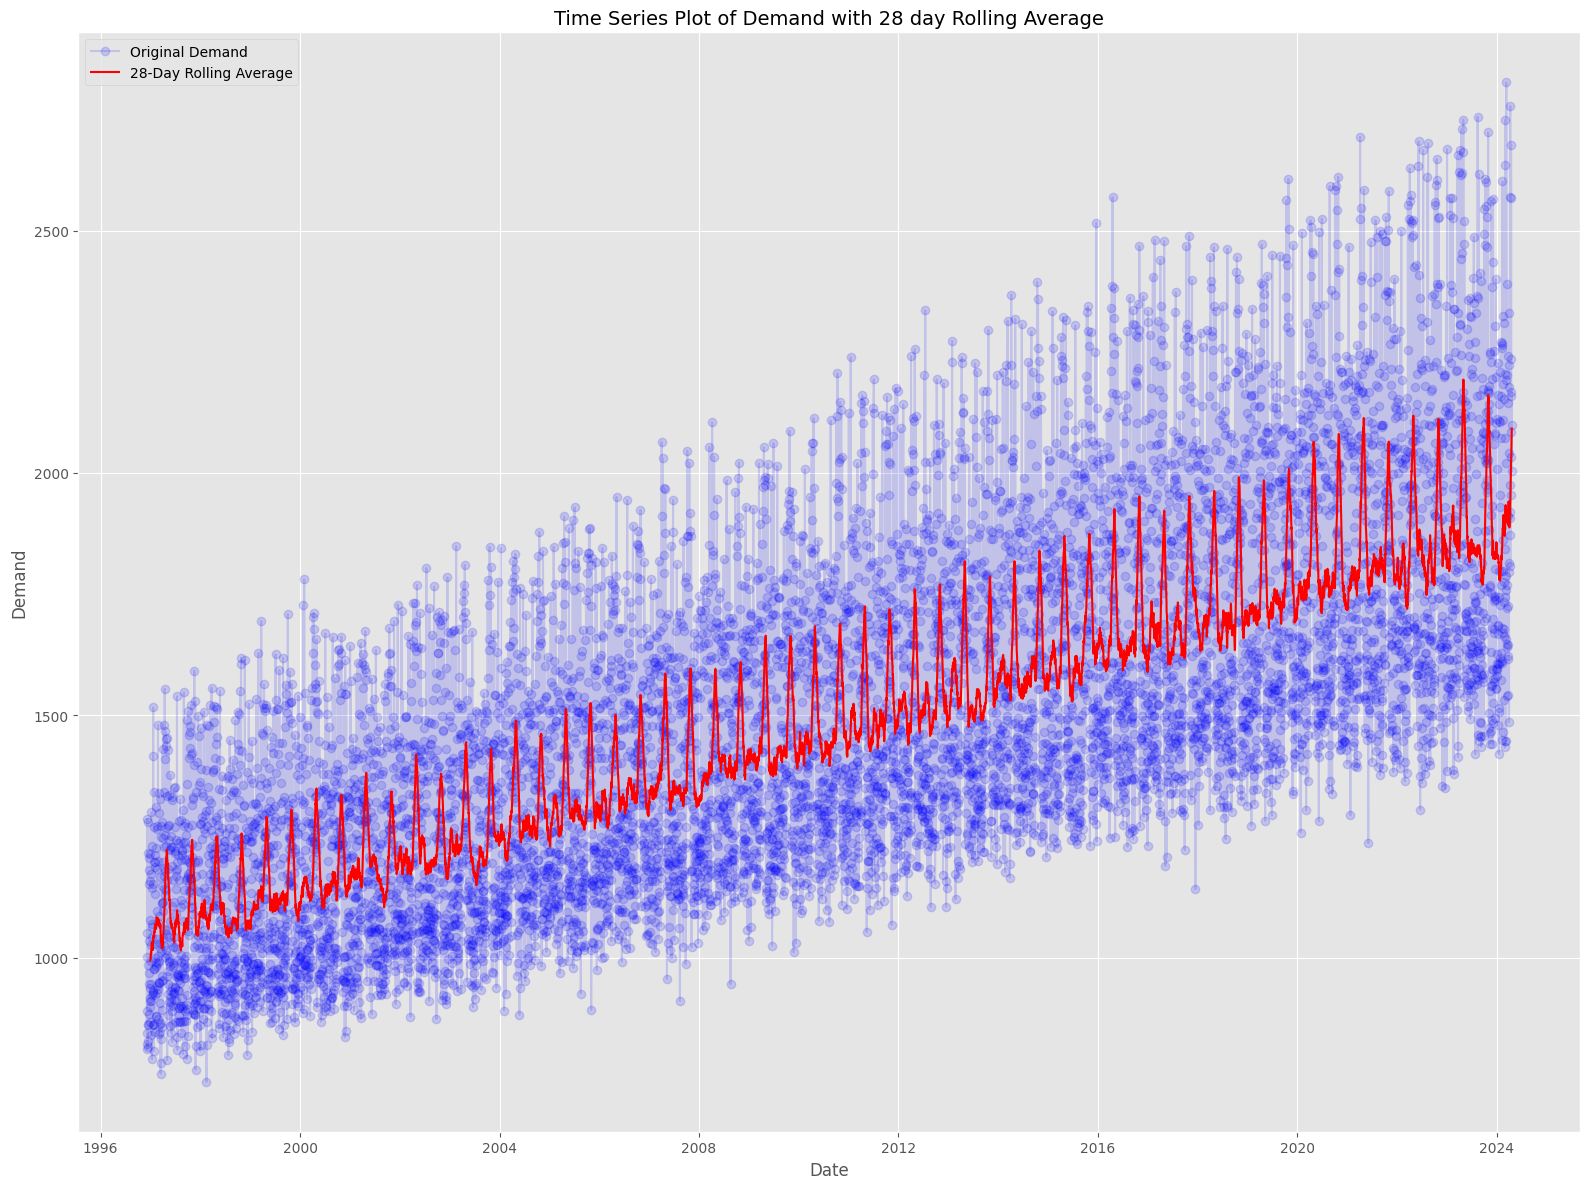

In [15]:
fig1 = plot_time_series_demand(df, window_size=28)
fig1

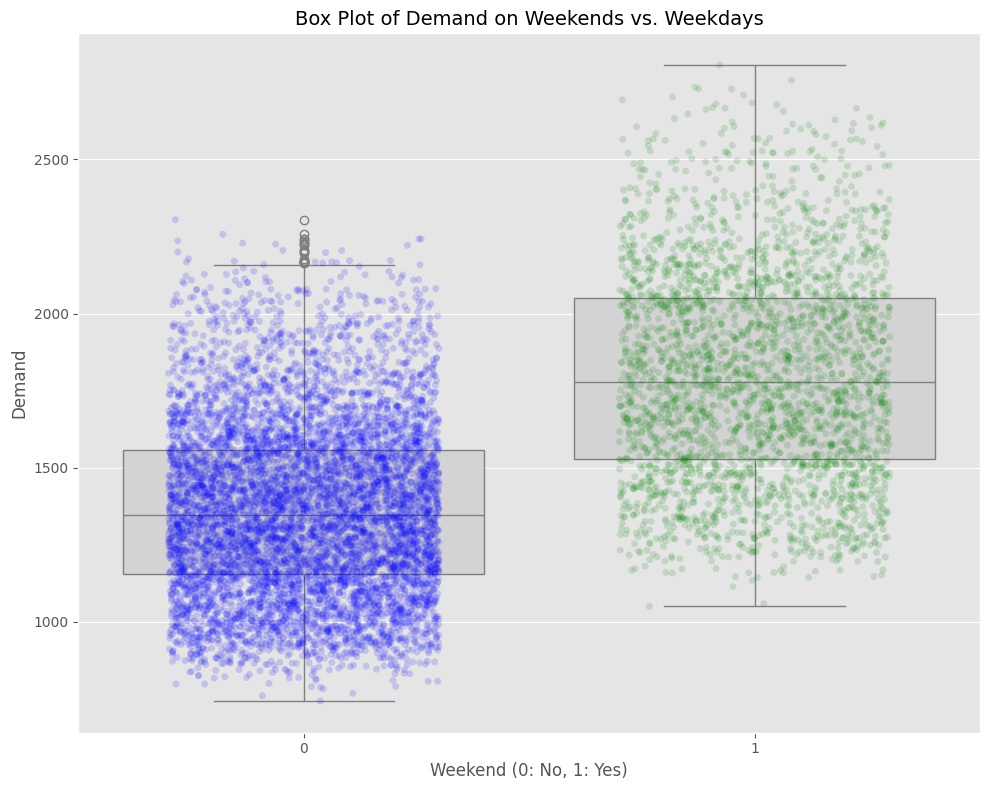

In [16]:
fig2 = plot_box_weekend(df)
fig2

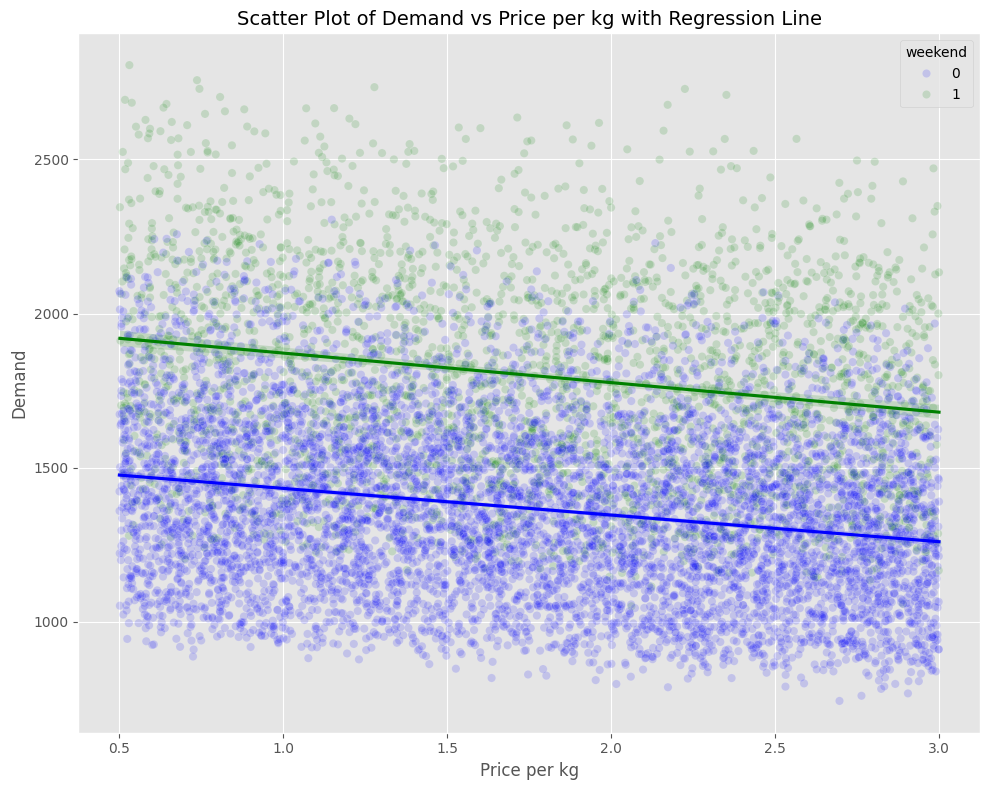

In [17]:
fig3 = plot_scatter_demand_price(df)
fig3

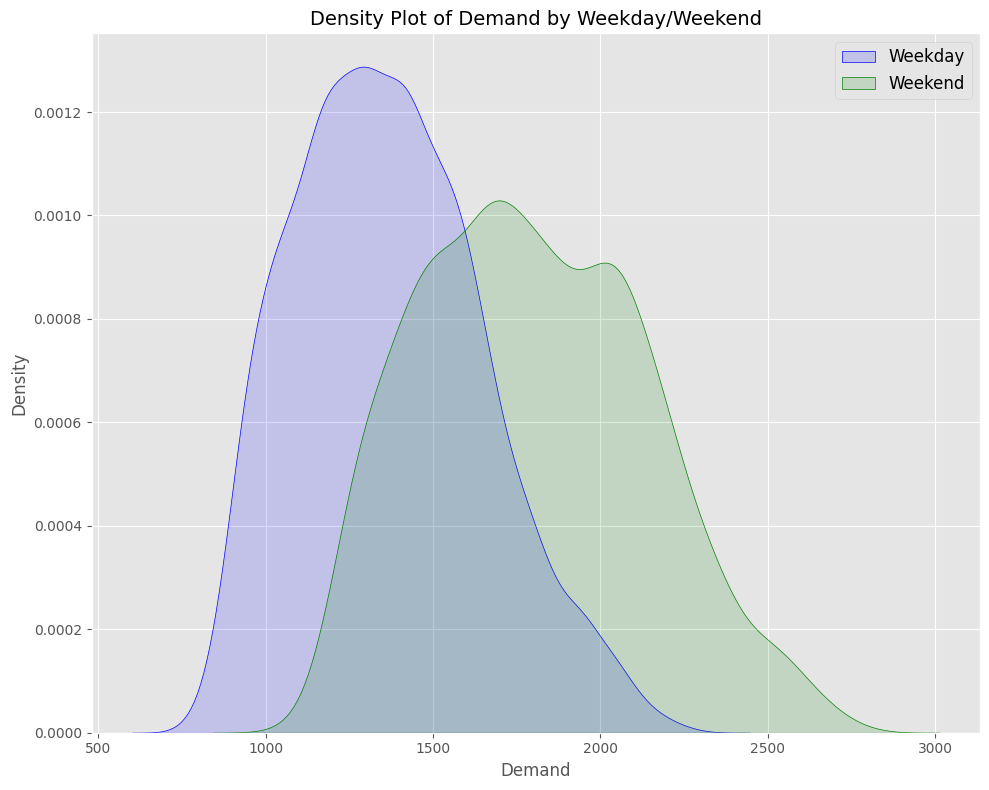

In [18]:
fig4 = plot_density_weekday_weekend(df)
fig4

In [19]:
## Execute the correlation plot, saving the plot to a local temporary directory
plot_correlation_matrix_and_save(df)

# Define our Ridge model
model = Ridge(alpha=1.0)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

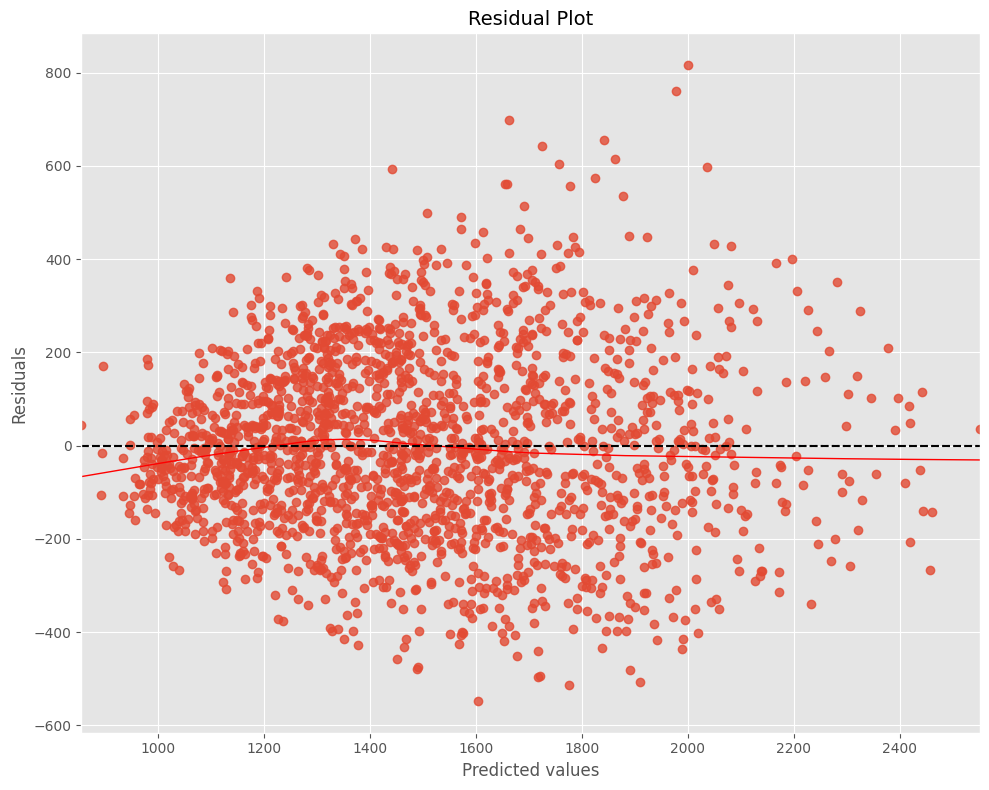

In [20]:
fig5 = plot_residuals(y_test, y_pred)
fig5

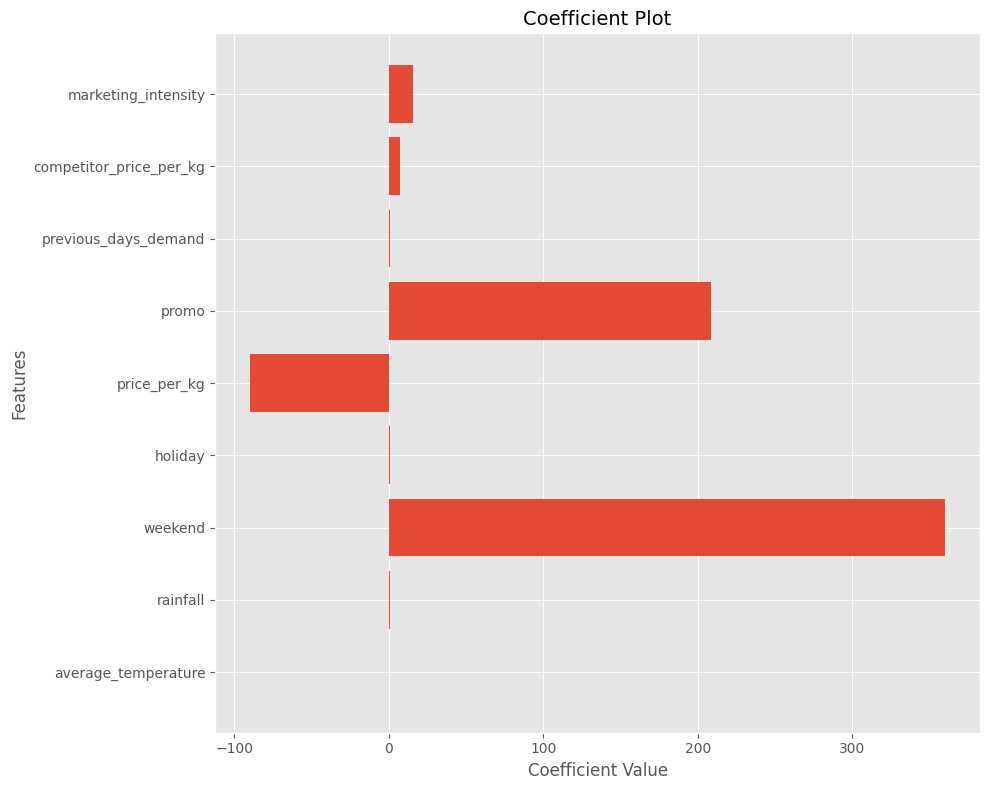

In [21]:
fig6 = plot_coefficients(model, X_test.columns)
fig6

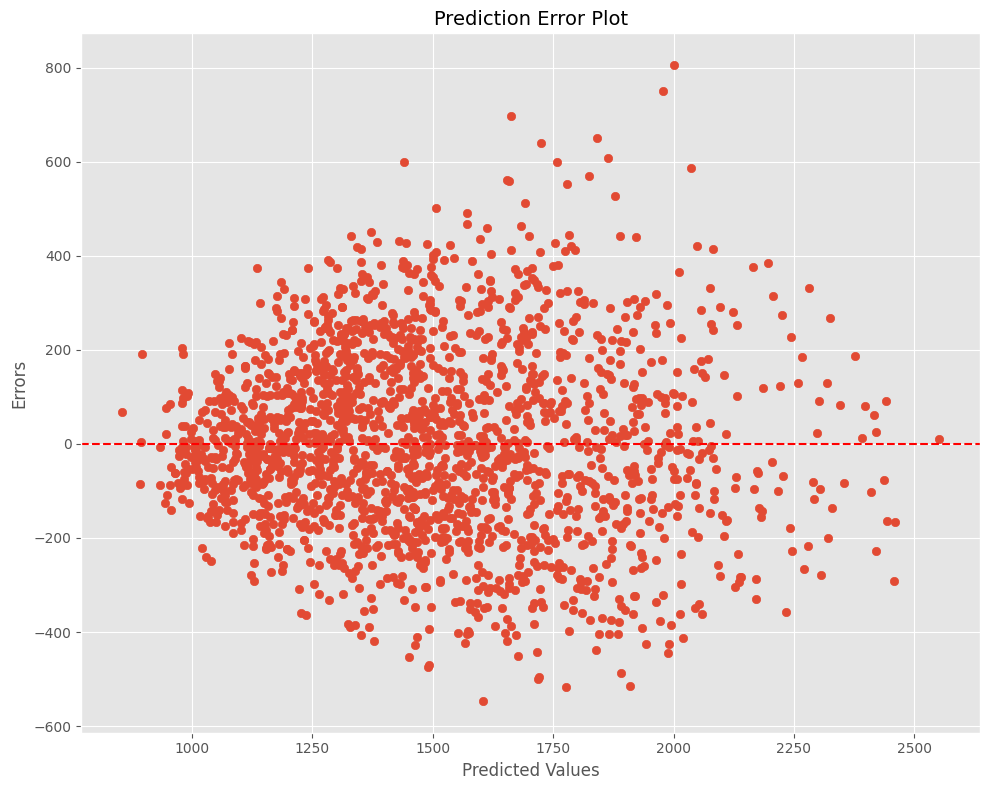

In [22]:
fig7 = plot_prediction_error(y_test, y_pred)
fig7

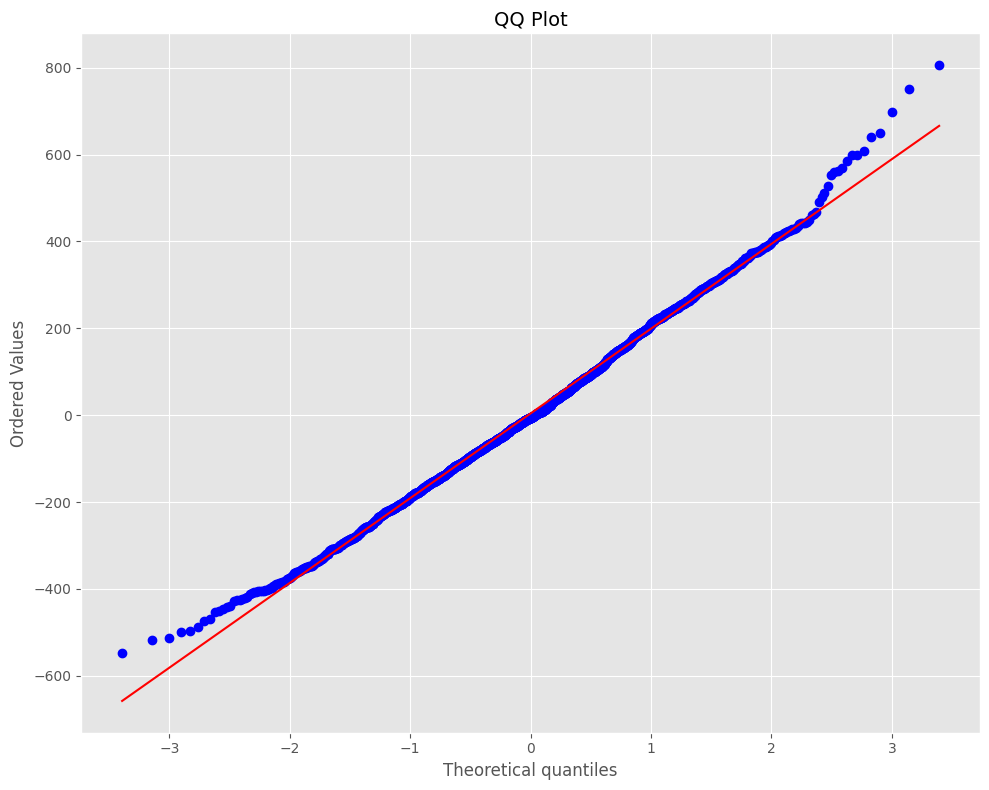

In [23]:
fig8 = plot_qq(y_test, y_pred)
fig8

`mlflow.log_figure()`により、対象の画像が実行結果に対するアーティファクトとして保存される。  
保存された後、Web UIよりどのように保存されたかを見てみよう。

In [24]:
# Start an MLflow run for logging metrics, parameters, the model, and our figures
with mlflow.start_run() as run:
    # Log the model
    mlflow.sklearn.log_model(sk_model=model, input_example=X_test, artifact_path="model")

    # Log the metrics
    mlflow.log_metrics(
        {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "msle": msle, "medae": medae}
    )

    # Log the hyperparameter
    mlflow.log_param("alpha", 1.0)

    # Log plots
    mlflow.log_figure(fig1, "time_series_demand.png")
    mlflow.log_figure(fig2, "box_weekend.png")
    mlflow.log_figure(fig3, "scatter_demand_price.png")
    mlflow.log_figure(fig4, "density_weekday_weekend.png")
    mlflow.log_figure(fig5, "residuals_plot.png")
    mlflow.log_figure(fig6, "coefficients_plot.png")
    mlflow.log_figure(fig7, "prediction_errors.png")
    mlflow.log_figure(fig8, "qq_plot.png")

    # Log the saved correlation matrix plot by referring to the local file system location
    mlflow.log_artifact("/tmp/corr_plot.png")

/home/user01/.local/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
